# Introduction

This notebook contains the steps necessary to generate the dataframe that includes all the opportunities based on our `best_seller_rank` prediction generated during modeling. Addtionally we will wrap all data transformation necessary to do inference of new items in one function that can be later used in our online tool.

In [16]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x) # number formating
from ast import literal_eval # Library for using columns as list after uploading
import re, string

# modeling packages
from sklearn.model_selection import train_test_split
import xgboost as xgb
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# metrics functions
from sklearn import metrics
from sklearn.metrics import mean_squared_error 
from xgboost import XGBRegressor

# Hypermeter tuning packages
from sklearn.model_selection import RandomizedSearchCV

# save model lib
import pickle

# Viz libraries
import plotly.express as px

In [17]:
path = '/content/drive/MyDrive/walmart_c1_bootcamp/'
df = pd.read_csv(path + 'data/df_after_eda.csv', index_col=0)

# printing features formated to facilitate our feature selection:
for i in df.columns:
  print('"'+i+'",')


"uniq_id",
"product_name",
"manufacturer",
"price",
"number_available_in_stock",
"number_of_reviews",
"number_of_answered_questions",
"average_review_rating",
"category_and_sub_category",
"customers_who_bought_this_item_also_bought",
"description",
"product_information",
"product_description",
"items_customers_buy_after_viewing_this_item",
"customer_questions_and_answers",
"customer_reviews",
"sellers",
"number_in_stock",
"type_of_stock",
"category",
"sub_category1",
"sub_category2",
"sub_category3",
"sub_category4",
"#_items_bought",
"desc_len",
"desc_#_numb",
"weight",
"weight_type",
"weight_g",
"dimension",
"volume",
"dimension_1",
"dimension_2",
"dimension_3",
"recom_age",
"information",
"info_len",
"info_#_numb",
"info_clean",
"model_no",
"assembly",
"radio_control",
"main_lang",
"educational_obj",
"mat_care_inst",
"mat_compostion",
"batteries",
"#_puzzle",
"#_players",
"batt_requi",
"batt_inc",
"remote_control",
"color",
"material_type",
"asin",
"main_cate",
"best_seller_rank",
"

In [18]:
# use all columns to clean features that will go to our app
# comments apply ot the rows above
features_to_keep = ["product_name",
                    # "manufacturer", # Not used anywhere
                    "price",
                    # "number_available_in_stock", # already extracted later
                    "number_of_reviews", 
                    "number_of_answered_questions",
                    "average_review_rating",
                    # "category_and_sub_category", # already extracted
                    # "customers_who_bought_this_item_also_bought",  #already extracted
                    # "description",  # repeated with product description
                    "product_information",
                    "product_description",
                    # "items_customers_buy_after_viewing_this_item", # already extracted
                    "customer_questions_and_answers", # already extracted, but will need still
                    # "customer_reviews", # not in use
                    # "sellers", # already extracted
                    "number_in_stock", 
                    # "type_of_stock", # not used
                    # "category",
                    # "sub_category1",
                    # "sub_category2",
                    # "sub_category3",
                    # "sub_category4", # all categories already extracted
                    "#_items_bought",
                    "desc_len",
                    "desc_#_numb",
                    "weight",
                    # "weight_type", # not used
                    # "weight_g",
                    "dimension",
                    # "volume",
                    # "dimension_1",
                    # "dimension_2",
                    # "dimension_3", # not used
                    "recom_age", 
                    # "information", # already extracted
                    "info_len",
                    "info_#_numb",
                    "info_clean", # already extracted
                    "model_no", 
                    "assembly",
                    # "radio_control", 
                    # "main_lang", # not used
                    "educational_obj", 
                    # "mat_care_inst", # not used
                    # "mat_compostion",
                    # "batteries", # already extracted
                    # "#_puzzle",
                    # "#_players", # not used
                    "batt_requi",
                    # "batt_inc", # already extracted
                    # "remote_control", # not used
                    "color",
                    "material_type", # already extracted
                    # "asin", # not used
                    # "main_cate",
                    "best_seller_rank",
                    # "pi_sub_category1",
                    # "pi_sub_category2",
                    # "pi_sub_category3",
                    # "pi_sub_category4",
                    # "pi_sub_category5",
                    # "pi_sub_category6",
                    # "pi_sub_category7",
                    # "pi_sub_category8", # already extracted
                    # "seller_rank",
                    # "ship_weight",
                    # "ship_weight_type",
                    # "ship_weight_g", # not. used
                    "deli_dest",
                    "first_del_date",
                    # "feedback",
                    "#_tech_details",
                    "#_items_bought_view",
                    "question_list",
                    # "answer_list",  #not used
                    # "#_questions",
                    # "#_answers", # not used
                    # "question_text",
                    # "answer_text", # already extracted
                    # "ave_length_question",
                    # "ave_length_answers",
                    # "que_#_numb",
                    # "ans_#_numb",
                    # "description_clean",
                    # "product_information_clean",
                    # "question_text_clean",
                    # "answer_text_clean",
                    # "info_key_weight",
                    # "info_key",
                    # "desc_key_weight",
                    # "desc_key",
                    # "ques_key_weight",
                    # "ques_key_914",
                    # "answer_key_weight",
                    # "answer_key_914",
                    # "ques_key_1679",
                    # "ans_key_1679",
                    # "ques_topic_list",
                    # "ans_topic_list", 
                    # "desc_info_sim", # not used
                    # "desc_ques_sim",
                    # # "desc_ans_sim",
                    # "info_ques_sim",
                    # "info_ans_sim",
                    # "ques_ans_sim",
                    # "desc_info", # not used
                    "desc_ques",
                    # "desc_ans",
                    # "info_ques",
                    # "info_ans",
                    # "ques_ans",
                    "category_eda",
                    "competitors_count",
                    "competitors_avg_price",
                    "OnlineRetail.co.uk",
                    "inferred-price",
                    # # "bsr_bucket",
                    # # "Size_q_topic",
                    # "Sound_q_topic",
                    # "Outliers_q_topic",
                    # "Track-Train_q_topic",
                    # "Material_q_topic",
                    # "Shipping_q_topic",
                    # "Color_q_topic",
                    # "Castle_q_topic",
                    # "DIY_q_topic",
                    # "Price_q_topic",
                    # "Age_q_topic",
                    # "Players_q_topic",
                    # "Cards_q_topic",
                    # "Kinetic-Sand_q_topic",
                    # "Pool_q_topic",
                    # "Door_q_topic",
                    # "Delivery_q_topic",
                    # "Battery_q_topic",
                    # "Baloon_q_topic",
                    # "Kite_q_topic", # already extracted
                    "predicted_sales",
                    "predicted_revenue",
                    # "bucket"
                    ]

len(features_to_keep)

38

In [19]:
features_to_model = [
                    # 'product_name',
                    'price',
                    'number_of_reviews',
                    'number_of_answered_questions', # multicolinearity with target
                    'average_review_rating',
                    # 'product_information',
                    # 'product_description',
                    # "customer_questions_and_answers", # 
                    'number_in_stock',
                    '#_items_bought', # multicolinearity with target
                    'desc_len',
                    'desc_#_numb',
                    # 'weight',
                    # 'dimension',
                    # 'recom_age',
                    # 'info_len',
                    # 'info_#_numb',
                    # 'info_clean',
                    # 'model_no',
                    # 'assembly',
                    # 'educational_obj',
                    # 'mat_compostion',
                    # 'batt_requi',
                    # 'color',
                    #  "best_seller_rank", # TARGET
                    # 'deli_dest',
                    # 'first_del_date', # will encode later
                    '#_tech_details',
                    '#_items_bought_view', # multicolinearity with target
                    # 'question_list', # no needed
                    'desc_ques', 
                    # 'category_eda', # will be one hot encoded
                    'competitors_count',
                    'competitors_avg_price',
                    # 'OnlineRetail.co.uk', 
                    # 'inferred-price', # very similar to our price
                    # 'predicted_sales',
                    # 'predicted_revenue' # multicolinearity with target
                     ]

                     

# Feature selection and generation

Based on our findings on our modeling notebook, we decided to work with a BERTopics, generating topics that are related to either the technical information that should be available on `product_information` or general product information that should be available on `product_description`. 

As our interest in this work is on how questions can help to improve `best_sellers_rank`, we will engineer new features that captures if there are unresponded questions for each product:
* BERTopic generate a number of topics present on questions
* For topics related to technical details, like dimensions or weight, we verify if the product has that information on the features already extracted from `product_infomation`.
* If there is a question related to the topic, but no information about it on our dataset, our new feature is `True`. 
* Any other scenario our new feature is `False`. This includes questions whose answers are theoretically available on our datase.
* For topics that are not technical, we fit the same model for each `product_description` which assigns a probability for each topic to be present on that text.
* If the $prob\_topic >= 0.1$ we consider the topic is present on that description.
* We encode it like the `product_information` related features: `True` means there is a question, but no information about that topic is detected on `product_description`. `False` means that either questions are answered, there are no questions, or the topic is not relevant.

To check the code that generated those features, refer to the notebook `3_text_processing.ipynb` on this same folder.

In [20]:
df_topics_encoded = pd.read_csv(path + 'data/df_topics_encoded.csv', index_col=0)
df_topics_encoded.head(2)

,description_clean,question_list,ques_topic_list_2,topic_0,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,...,coded_10,coded_11,coded_12,coded_13,coded_14,coded_15,coded_16,coded_17,coded_18,coded_19
0,product description hornby catalogue box conta...,['Does this catalogue detail all the previous ...,[0],0,1,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,size name large funky buys large christmas hol...,['can you turn off sounds'],[8],0,1,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [21]:
# import model to see topic naming:
BERTopic_model = BERTopic.load(path + 'models/bertopic_model')
BERTopic_model.get_topic_info()

,Topic,Count,Name
0,-1,414,-1_does_size_tell_just
1,0,619,0_size_box_does_come
2,1,84,1_pump_pool_water_does
3,2,83,2_track_train_compatible_brio
4,3,64,3_plastic_metal_durable_paper
5,4,62,4_cards_25_pokemon_deck
6,5,46,5_old_year_suitable_ok
7,6,42,6_use_dry_stick_pens
8,7,41,7_colour_red_colours_blue
9,8,34,8_sounds_sound_does_music


In [22]:
# topics that are technical-info-related:
tech_topics = [0,3,5,7,9,13,14]
desc_topics = [1,2,4,6,8,10,11,12,15,16,17,18,19]

eq_tech_features = ['dimension', 'material_type', 'recom_age', 'color', 
                    'first_del_date', 'batt_requi', 'deli_dest']

for i in eq_tech_features:
  df[f'{i}_code'] = df[i].notnull().astype(int)

# replace coded features on tech topics by our extracted tech features
for i in range(10000):
  for j in tech_topics:
    for k in range(len(eq_tech_features)):
      if (df[f'{eq_tech_features[k]}_code'][i] == 0):
        if(df_topics_encoded[f'prob_{k}'][i] == 1):
          df_topics_encoded[f'coded_{k}'][i] = 1
      else:
        df_topics_encoded[f'coded_{k}'][i] = 0



In [23]:
df_topics_encoded['ques_topic_list_2'][7750]

'[2, 2]'

In [24]:
df_topics_encoded.columns

Index(['description_clean', 'question_list', 'ques_topic_list_2', 'topic_0',
       'prob_0', 'prob_1', 'prob_2', 'prob_3', 'prob_4', 'prob_5', 'prob_6',
       'prob_7', 'prob_8', 'prob_9', 'prob_10', 'prob_11', 'prob_12',
       'prob_13', 'prob_14', 'prob_15', 'prob_16', 'prob_17', 'prob_18',
       'prob_19', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', 'coded_0', 'coded_1',
       'coded_2', 'coded_3', 'coded_4', 'coded_5', 'coded_6', 'coded_7',
       'coded_8', 'coded_9', 'coded_10', 'coded_11', 'coded_12', 'coded_13',
       'coded_14', 'coded_15', 'coded_16', 'coded_17', 'coded_18', 'coded_19'],
      dtype='object')

In [25]:
# remove not used columns (or columns we already captured somewhere else)
df = df.filter(features_to_keep)

# add BERT encoded question-description and question-info features
df = df.join(df_topics_encoded[(f'coded_{i}' for i in range(20))])

# one hot encoding our categories
one_hot = pd.get_dummies(data=df['category_eda'])
df.drop('category_eda', axis=1)

df = df.join(one_hot)

# finally adding our coded features to model list:
features_to_model = features_to_model + ['coded_0', 'coded_1', 'coded_2',
       'coded_3', 'coded_4', 'coded_5', 'coded_6', 'coded_7', 'coded_8',
       'coded_9', 'coded_10', 'coded_11', 'coded_12', 'coded_13', 'coded_14',
       'coded_15', 'coded_16', 'coded_17', 'coded_18', 'coded_19',
       'Advent Calendars', 'Arts & Crafts', 'Baby & Toddler Toys',
       'Building & Construction Toys', 'Characters & Brands',
       'Die-Cast & Toy Vehicles', 'Dolls & Accessories', 'Fancy Dress',
       'Figures & Playsets', 'Games', 'Hobbies', 'Jigsaws & Puzzles',
       'Musical Toy Instruments', 'Novelty & Special Use', 'Other',
       'Party Supplies', 'Pretend Play', 'Puppets & Puppet Theatres',
       'Soft Toys', 'Sports Toys & Outdoor']

In [26]:
# features that we can do something about:
actionable_features = [
                      # 'price', #we won't chance price, this is a business decision
                      # 'average_review_rating',
                      # 'number_in_stock',
                      'desc_len', 
                      'desc_#_numb',
                      '#_tech_details', # the last 3 are technical actionable, but without description it doesn't make business sense.
                      # 'question_list', # we don't create questions
                      'desc_ques', 
                      # 'category_eda',
                      # 'competitors_count',
                      # 'competitors_avg_price',
                      'coded_0',
                      'coded_1',
                      'coded_2',
                      'coded_3',
                      'coded_4',
                      'coded_5',
                      'coded_6',
                      'coded_7',
                      'coded_8',
                      'coded_9',
                      'coded_10',
                      'coded_11',
                      'coded_12',
                      'coded_13',
                      'coded_14',
                      'coded_15',
                      'coded_16',
                      'coded_17',
                      'coded_18',
                      'coded_19'
                      ] # also no categories should be changed.


# Training Model

With the features above, we can train our model according to the findings on our notebook `modeleing_finalize.ipynb`. Note we will use a subset of products where we have `number_of_answered_questions` = 0 or `number_of_answered_questions` > 0 and `questions` is not empty.

This will avoid using products to train our model that have questions, but that were not available on our dataset due to data collection issues.

In [27]:
# filter dataset for training and products with no target feature (best_seller_rate)
df_model = df
df_model.dropna(subset=['best_seller_rank'], inplace=True)

df_model.shape

(9866, 78)

In [28]:
# define X and y
y = df_model['best_seller_rank']
X = df_model.filter(features_to_model)

print(f"y shape: {y.shape},X shape: {X.shape} ")
print()
# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# Check the shapes of all features
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, y_train:{y_train.shape}, y_test:, {y_test.shape}')

y shape: (9866,),X shape: (9866, 53) 

X_train: (7892, 53), X_test: (1974, 53), y_train:(7892,), y_test:, (1974,)


In [29]:
model_xgb = XGBRegressor()
# Fit and predict
model_xgb.fit(X_train, y_train)
pred = model_xgb.predict(X_test)

# Metrics
print(f"MAE: {metrics.mean_absolute_error(y_test, pred)}")
print(f"MSE: {metrics.mean_squared_error(y_test, pred)}")
print(f"R2: {metrics.r2_score(y_test, pred)}")

[07:29:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 104519.20076135638
MSE: 23490607833.80874
R2: 0.64646739994873


In [30]:
feature_importances = pd.DataFrame()
feature_importances['columns']= X.columns
feature_importances['importances'] = model_xgb.feature_importances_
feature_importances.sort_values(by='importances',ascending=False,inplace=True)

fig = px.bar(feature_importances, y='columns', x='importances')
fig.show()

In [31]:
# save model for use on dash
pickle.dump(model_xgb, open(path + 'models/xgb_regressor.pickle', 'wb'))

In [42]:
# saving the model using xgboost library because support to
# pickle will be eventually deprecated
model_xgb.save_model(path + 'models/model_xgb.json')

In [43]:
xgb.Booster().load_model(path + 'models/model_xgb.json')

[07:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [45]:
!pip upgrade xgboost

ERROR: unknown command "upgrade"


# Generating opportunities:

On notebook `modeling_finalize.ipynb` we created a regressor model that predicts our best seller rank given the features mentioned above. 
Now, we are able to manipulate the actionable variables to see how each variable can improve our `best_seller_rank`.

Observing our list `actionable_features` we notice that the ones related to question topics can be easily changed to 0 to simulate questions were answered or not present.

The similarity indexes are more difficult and we will simulate it's actiona by increasing the similarity by 5%.

Features like `description_lenght` were left behind because they can mistaken the model to place products better even if descriptions are random text. We will adjust those as we improve predictions, though.


In [32]:
# assumption that a better description can improve similarity by 5%
sim_improve = 0.05

# assumption that a better description will be, at least, 20% longer. 
len_improve = 1.2

# assumption that a better description will have, at least, 20% mode numbers.
num_no_improve = 1.2 

# NOTE: these are topic-dependent and re-running the model might need 
# eventually we can evolve to generage automatic labeling based on other model
dict_actions = {'desc_ques': 'Elaborate on topics on Questions',
                'coded_0': 'Insert dimension info',
                'coded_1': 'Pools and accessories',
                'coded_2': 'Model Trains',
                'coded_3': 'Insert materials info',
                'coded_4': 'Cards',
                'coded_5': 'Insert recommended age',
                'coded_6': 'Arts and Coloring',
                'coded_7': 'Insert color info',
                'coded_8': 'Sounds and voices',
                'coded_9': 'Insert delivery time',
                'coded_10':'Kinect Sand',
                'coded_11': 'Baloons',
                'coded_12': 'Tattoos and makeup',
                'coded_13': 'Insert batteries info',
                'coded_14': 'Insert country shipping info',
                'coded_15': 'Price',
                'coded_16': 'Kite',
                'coded_17': 'Model actions',
                'coded_18': 'Painting',
                'coded_19': 'Role play'}


df_improved = df_model


# predicting improvement improving all features at once:

for j in actionable_features:
    if j == 'desc_len':
      df_improved[j] = df_improved[j]*len_improve
    elif j == 'desc_#_numb':
      df_improved[j] = df_improved[j]*num_no_improve
    elif j == '#_tech_details':
      df_improved[j] = len(tech_topics) # best case scenario is all tech details available
    elif j == 'desc_ques':
      df_improved[j] = df_improved[j] + 0.05
    else:
      df_improved[j] = 0 # all questions about all topics answered.

X_improved = df_improved.filter(features_to_model)

# making predictions
df_improved['predictions'] = model_xgb.predict(X_improved)

# now calculating delta:
df_improved['bsr_improvement'] = df_improved['best_seller_rank'] - df_improved['predictions']

df_improved['bsr_improvement'].describe()


count      9866.00000
mean     -57752.77655
std      149530.44309
min     -778857.25000
25%     -134258.27344
50%      -63198.97656
75%        6528.78906
max     1534123.25000
Name: bsr_improvement, dtype: float64

In [33]:
px.scatter(df_improved, x='predictions', y='best_seller_rank')

It is interesting to see that our predictions are usually bad when `best_seller_rank` is lower than 100,000. These effect can possibly be explained by the low amount of training data on this area.

For this proof of concept we will disregard columns where the prediction is worst than the current rank assuming no customer would not buy a product due to excess of information about it. While our assumption is intuitive, we recommend revisiting it on a later date, when more data is brought into our app.

In [34]:
# get rid of "negative" improvements
df_improved['bsr_improvement'] = df_improved['bsr_improvement'].clip(lower=0)

Finally we will utilize a estimation of sales available online. These are models that based on a country, product category, and sales rank, predict how many units are sold per month. For this POC we downloaded points and, after unsuccesfull attempts to fit an exponential function, we decided to model sales in a 'linear-by-parts' function.

Due to the exponential character of the function, we may be overshooting the sales improvement a bit, but this is acceptable for this proof of concept.

In [35]:
sales_est = pd.DataFrame({'bsr': [1,5,10,17,20,38,49,50,55,67,72,88,93,100,250,
                                  500,1000,2000,3000,4000,6000,8000,10000,15000,
                                  20000,25000,30000,35000,40000,70000],
                          'monthly_sales':[13367,10011,8573,8020,7783,6362,5493,5414,
                                           5296,5011,4893,4514,4396,4230,2968,
                                           2129,1445,937,673,557,399,388,324,220,
                                           151,85,18,3,2,1]})

def sales_pred(x_data, y_data, x):
  try:
    for i in range(len(x_data)):
      x1 = x_data[i]
      x2 = x_data[i+1]
      y1 = y_data[i]
      y2 = y_data[i+1]
      if x1 <= x <= x2:
        slope = (y2 - y1)/(x2 - x1)
        y_intercept = y1 - slope * x1
        y = slope * x + y_intercept
        return round(y)
  except: # when more than our last point, return the last point
    return y_data.iloc[-1]

# calculating improvement
df_improved['sales_improvement'] = df_improved['predictions'].apply(lambda x: sales_pred(sales_est['bsr'], sales_est['monthly_sales'],x)) * df_improved['price'] - df_improved['predicted_revenue']
df_improved['sales_improvement'] = df_improved['sales_improvement'].clip(lower=0)

df_improved[['product_name', 'sales_improvement']].sort_values('sales_improvement', ascending=False)

,product_name,sales_improvement
7734,Thomas & Friends Wooden Railway Battery Operat...,39924.95000
367,Keel Toys 20cm Sitting Panda,19614.17000
3574,German Panther Medium Tank - 1:35 Scale Milita...,5216.12000
9225,VTech InnoTab Software: Hello Kitty - A Day wi...,4013.50000
7864,Bruder 02019 Tipping Trailer,3679.00000
...,...,...
3371,Scary Vampiress - Kids Costume 5 - 7 years,0.00000
3372,Oxford Diecast Daimler DS420 Black Hearse 76DS002,0.00000
3373,Focke Wulf 190,0.00000
3374,burago red and white mini cooper car 1.24 scal...,0.00000


In [36]:
df_improved[['product_name', 'best_seller_rank', 'predictions']].loc[9225]

product_name        VTech InnoTab Software: Hello Kitty - A Day wi...
best_seller_rank                                          66857.00000
predictions                                                9201.65625
Name: 9225, dtype: object

In [37]:
# Finally, we are interested on the products we can improve, therefore let's restrict the DF
# and leave a few more for reference
improv_df_size = df_improved.shape[0] - df_improved[df_improved['sales_improvement']==0].shape[0] + 100

print('Number of products we can possibly improve: ' + str(improv_df_size))

# Finally exporting the df for use in the UI
df_improved_sorted = df_improved.sort_values('sales_improvement', ascending=False)[:improv_df_size]
df_improved_sorted.to_csv(path + 'data/df_for_dash.csv')

Number of products we can possibly improve: 155


# Generating custom predictions

We want to be able to generate predictions based on changes we do in real time in our UI. For this we can. use the models we created.

In [38]:
# let's use the forth on our list as example:
print(df_improved.loc[9225][features_to_model])

price                           11.50000
number_of_reviews                     43
number_of_answered_questions           1
average_review_rating            4.20000
number_in_stock                       15
#_items_bought                   6.00000
desc_len                       150.00000
desc_#_numb                      2.40000
#_tech_details                         7
#_items_bought_view              4.00000
desc_ques                        0.36486
competitors_count                     10
competitors_avg_price           11.53000
coded_0                                0
coded_1                                0
coded_2                                0
coded_3                                0
coded_4                                0
coded_5                                0
coded_6                                0
coded_7                                0
coded_8                                0
coded_9                                0
coded_10                               0
coded_11        

In [39]:
df.loc[9225]['product_description']

'Product Description Come spend a day with Hello Kitty and her friends in this educational software title for VTech\'s InnoTab systems. But it\'s not just any day – it\'s Hello Kitty\'s birthday! Read the e-book "Hello Kitty\'s Surprise" to find out how Hello Kitty spent her birthday, or join in the celebration and play one of three party-themed touchscreen learning games. You can also make a Hello Kitty greeting card or import your own photos into a digital Hello Kitty photo album in the two creative activities. As your child plays with Hello Kitty on their InnoTab, they\'ll develop essential skills in counting, addition, logic, and memorisation! This software is compatible with all InnoTab learning tablets. Box Contains 1 x Software cartridge1 x User manual'

In [40]:
df.loc[9225]['question_list']

"['Hi, does this cartridge work with Innotech Vtech 3S?']"

With that information, we can rewrite the description to match the existing question, or even ustilize a model to rewrite the descrition:

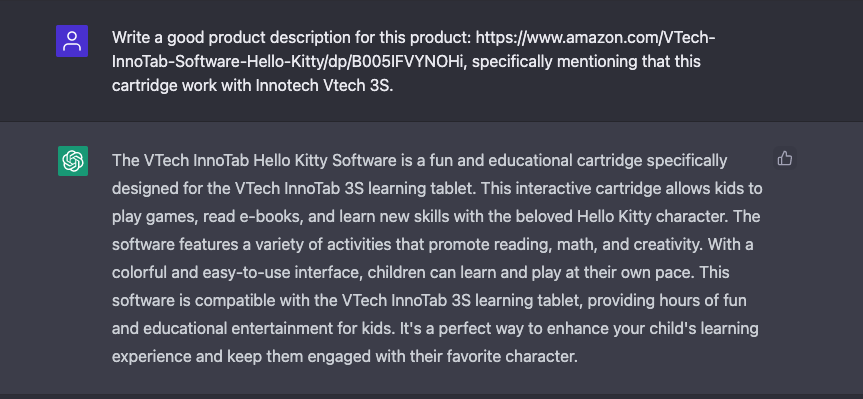

In [41]:
from sklearn.metrics.pairwise import cosine_similarity
# let change description to:
new_desc = '''The VTech InnoTab Hello Kitty Software is a fun and educational 
              cartridge specifically designed for the VTech InnoTab 3S learning 
              tablet. This interactive cartridge allows kids to play games, 
              read e-books, and learn new skills with the beloved Hello Kitty 
              character. The software features a variety of activities that 
              promote reading, math, and creativity. With a colorful and 
              easy-to-use interface, children can learn and play at their own 
              pace. This software is compatible with the VTech InnoTab 3S 
              learning tablet, providing hours of fun and educational 
              entertainment for kids. It's a perfect way to enhance your 
              child's learning experience and keep them engaged with their 
              favorite character.'''

original_index = 9225

remove = string.punctuation
remove = remove.replace(".", "")
pattern = r"[{}]".format(re.escape(remove))

def remove_pu(x):
  x = re.sub(pattern, "", x)
  return x

clean = remove_pu(new_desc)

# spin up bert models for generating vectors to the new desc:
model = SentenceTransformer('bert-base-nli-mean-tokens')
new_desc_embeddings = model.encode(clean)
new_desc_vec = pd.DataFrame(new_desc_embeddings)

# import existing bert vectors for the question
question_def_vectors = pd.read_csv(path + 'data/question_bert_vector.csv', index_col=0).loc[original_index]

# generating the values based on description
desc_len = len(new_desc.split(' '))
desc_no_numb = num = len(re.findall(r'([0-9]+ )|([0-9]+[.:]+[0-9]+)|([0-9]+.)', new_desc)) 
no_tech_details = 4 # all details available

# calculating similarity
sim = np.dot(new_desc_vec.transpose(), pd.DataFrame(question_def_vectors))/(np.linalg.norm(new_desc_vec.transpose())*np.linalg.norm(question_def_vectors))

print('Previous similarity: ' + str(df_improved['desc_ques'][original_index]) + ', New similarity: ' + str(sim[0][0]))

# finally let's predict the new BSR:
row_to_predict = df_improved[df_improved.index == original_index]
row_to_predict.at[0, 'desc_len'] = desc_len
row_to_predict.at[0, 'desc_#_numb'] = desc_no_numb
row_to_predict.at[0, '#_tech_details'] = no_tech_details
row_to_predict.at[0, 'desc_ques'] = sim[0][0]

bsr = model_xgb.predict(row_to_predict[features_to_model])

print('Predicted BSR: '+ str(bsr[0]) + ' - Old BSR: ' + str(df_improved['best_seller_rank'][original_index]))




Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Previous similarity: 0.36486195, New similarity: 0.39227794296713714
Predicted BSR: 9201.656 - Old BSR: 66857.0


# Conclusion

* The work on this notebook shows that the concept have potential to work, but the data collected is not enough to draw more accurate conclusions. there are several improvements that were thought as next steps: 
  * To better predict on better perfomring products, we can utilize a classification technique, training models for each category.
  * With mode data, we will be able to have questions and topics for all categories, solving some of our issues of accuracy.
  * We can extraploate our fidings to products without questions, assuming similar products need similar information to be attractive to public.
  * On production environment we can deploy not only the regression model, but also the heavier text models (BERT and BERTopic). With that we can improve inference in real time and enable marketer to experiment with product descriptions.


Finally, we are ready to move the work on this notebook and the attached user interface into a MLOps pipeline, where we could not only use more data but retrain our models in a rolling basis, improving the results considerably.